In [1]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
input_img = Input(shape=(256, 256, 3))

l1 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)
encoder = Model(input_img, l7)

In [3]:
encoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)    

In [4]:
l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])

# chan = 3, for RGB
decoded = Conv2D(3, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)

# Create our network
autoencoder = Model(input_img, decoded)
# You'll understand later what this is
autoencoder_hfenn = Model(input_img, decoded)

In [5]:
autoencoder.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [6]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [7]:
from os import listdir
from matplotlib import image
from skimage.transform import resize, rescale
import cv2
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np

In [8]:
filename="0001.png"
img_data = image.imread('/content/drive/My Drive/DIV2K_train_HR/' + filename)
image_resized = resize(img_data, (256, 256))

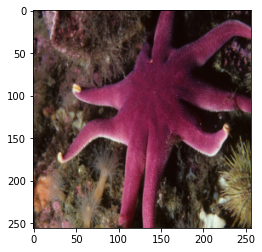

In [9]:
plt.imshow(image_resized)

In [10]:
scale_percent = 50
src=image_resized
width = int(src.shape[1] * scale_percent / 100)
height = int(src.shape[0] * scale_percent / 100)

In [11]:
dsize = (width, height)

In [12]:
output = cv2.resize(src, dsize)

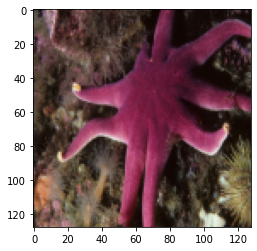

In [13]:
plt.imshow(output)

In [14]:
rescaled=cv2.resize(output, (256,256))

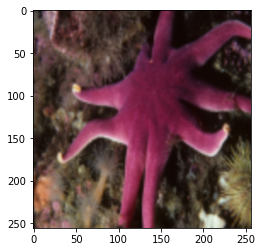

In [15]:
plt.imshow(rescaled)

In [16]:
import random
def shuffle(samples):
    shuffled=random.sample(samples, len(samples))  
    return shuffled

In [17]:
samples=[]
for filename in listdir('/content/drive/My Drive/DIV2K_train_HR'):
  samples.append(filename)
  print(filename +" Name uploaded to Samples")

0003.png Name uploaded to Samples
0008.png Name uploaded to Samples
0004.png Name uploaded to Samples
0010.png Name uploaded to Samples
0012.png Name uploaded to Samples
0002.png Name uploaded to Samples
0009.png Name uploaded to Samples
0001.png Name uploaded to Samples
0006.png Name uploaded to Samples
0005.png Name uploaded to Samples
0011.png Name uploaded to Samples
0007.png Name uploaded to Samples
0020.png Name uploaded to Samples
0026.png Name uploaded to Samples
0017.png Name uploaded to Samples
0013.png Name uploaded to Samples
0023.png Name uploaded to Samples
0016.png Name uploaded to Samples
0018.png Name uploaded to Samples
0024.png Name uploaded to Samples
0021.png Name uploaded to Samples
0028.png Name uploaded to Samples
0019.png Name uploaded to Samples
0027.png Name uploaded to Samples
0015.png Name uploaded to Samples
0030.png Name uploaded to Samples
0031.png Name uploaded to Samples
0029.png Name uploaded to Samples
0025.png Name uploaded to Samples
0014.png Name 

In [18]:
def generator(samples,batch_size=10):
    num_samples = len(samples)
    while True:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            X_train = []
            y_train = []
            for sample_file in batch_samples:
                img_data = image.imread('/content/drive/My Drive/DIV2K_train_HR/'+sample_file)
                image_resized = resize(img_data, (256, 256))
                output = cv2.resize(image_resized, dsize)
                X_train.append(image_resized)
                y_train.append(cv2.resize(output, (256,256)))
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            yield X_train, y_train

In [19]:
train_datagen = generator(samples)

In [21]:
model=autoencoder.fit(train_datagen,epochs=20,steps_per_epoch=20,verbose=1)

Epoch 1/20
20/20 [==============================] - 384s 19s/step - loss: 0.2343
Epoch 2/20
20/20 [==============================] - 400s 20s/step - loss: 0.2364
Epoch 3/20
20/20 [==============================] - 400s 20s/step - loss: 0.2255
Epoch 4/20
20/20 [==============================] - 88s 4s/step - loss: 0.2156
Epoch 5/20
20/20 [==============================] - 89s 4s/step - loss: 0.2191
Epoch 6/20
20/20 [==============================] - 89s 4s/step - loss: 0.2193
Epoch 7/20
20/20 [==============================] - 90s 4s/step - loss: 0.2039
Epoch 8/20
20/20 [==============================] - 88s 4s/step - loss: 0.1876
Epoch 9/20
20/20 [==============================] - 88s 4s/step - loss: 0.1835
Epoch 10/20
20/20 [==============================] - 87s 4s/step - loss: 0.1780
Epoch 11/20
20/20 [==============================] - 88s 4s/step - loss: 0.1629
Epoch 12/20
20/20 [==============================] - 87s 4s/step - loss: 0.1493
Epoch 13/20
20/20 [========================

In [22]:
autoencoder.save("/content/drive/My Drive/IoTDemo/srautoencoder.h5")

In [23]:
print(model.history.keys())

dict_keys(['loss'])


Text(0.5, 0, 'epoch')

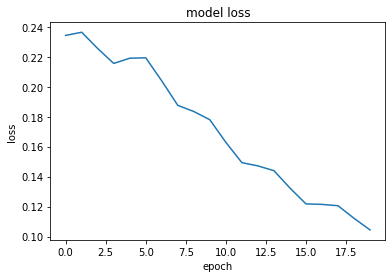

In [25]:
plt.plot(model.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [26]:
from keras.models import load_model
SuperRes=load_model('/content/drive/My Drive/IoTDemo/srautoencoder.h5')

In [27]:
SuperRes.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

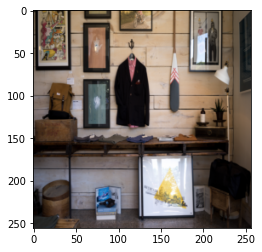

In [34]:
testimg="0001.png"
testimg_data = image.imread('/content/drive/My Drive/DIV2K_train_HR/' + testimg)
testimage_resized = resize(img_data, (256, 256))
plt.imshow(testimage_resized)

In [35]:
testscale_percent = 50
testsrc=testimage_resized
testwidth = int(testsrc.shape[1] * testscale_percent / 100)
testheight = int(testsrc.shape[0] * testscale_percent / 100)

In [36]:
testdsize = (testwidth, testheight)

In [37]:
testoutput = cv2.resize(testsrc, testdsize)

In [38]:
testrescaled=cv2.resize(testoutput, (256,256))

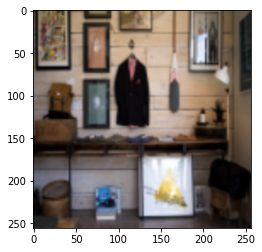

In [39]:
plt.imshow(testrescaled)